In [171]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
'''
Adapted from code by Ian Osband
https://github.com/iosband/ts_tutorial/

Run experiment on extrasensory data
Policy: uniform random, posterior sampling
'''

import os
import sys

import numpy as np
import pandas as pd
import plotnine as gg

from base.experiment import BaseExperiment
from al.env_al import ContextualBanditFunctionalContext, ContextualBanditDataFileContext #FiniteArmedBernoulliBandit
from al.agent_al import SelectiveSampleBBQ, UniformRandom #FiniteBernoulliBanditTS
from al.env_al import normal_iid, uniform_iid, sinewave, linear_classifier

sys.path.append(os.getcwd())

In [173]:
from al.env_al import read_data

data = read_data('../data/adult.csv')

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/harvineetsingh/Documents/New Volume/courses/lab/projects/seqd/rlsamp/src/al/env_al.py:25: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  data.iloc[:,0:123] = scaler.transform(data.iloc[:,0:123])


In [174]:
data

,age,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,fnlwgt,education_ 10th,...,native_region_ Outlying-US,native_region_ South-America,native_region_ United-States,cap_gain_ Low,cap_gain_ Medium,cap_gain_ High,cap_loss_ Low,cap_loss_ Medium,cap_loss_ High,income
0,0.880275,-0.179651,-0.271246,-1.682251,-0.192155,3.327045,-0.210351,-0.02155,-1.007909,-0.167174,...,-0.112959,-0.061324,0.310876,0.259798,-0.208799,-0.148060,0.194371,-0.162935,-0.103227,-1
1,-0.033338,-0.179651,-0.271246,0.594442,-0.192155,-0.300567,-0.210351,-0.02155,0.244659,-0.167174,...,-0.112959,-0.061324,0.310876,0.259798,-0.208799,-0.148060,0.194371,-0.162935,-0.103227,-1
2,1.108678,-0.179651,-0.271246,0.594442,-0.192155,-0.300567,-0.210351,-0.02155,0.425206,-0.167174,...,-0.112959,-0.061324,0.310876,0.259798,-0.208799,-0.148060,0.194371,-0.162935,-0.103227,-1
3,-0.794682,-0.179651,-0.271246,0.594442,-0.192155,-0.300567,-0.210351,-0.02155,1.406626,-0.167174,...,-0.112959,-0.061324,-3.216715,0.259798,-0.208799,-0.148060,0.194371,-0.162935,-0.103227,-1
4,-0.109472,-0.179651,-0.271246,0.594442,-0.192155,-0.300567,-0.210351,-0.02155,0.897147,-0.167174,...,-0.112959,-0.061324,0.310876,0.259798,-0.208799,-0.148060,0.194371,-0.162935,-0.103227,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30156,-0.870817,-0.179651,-0.271246,0.594442,-0.192155,-0.300567,-0.210351,-0.02155,0.638938,-0.167174,...,-0.112959,-0.061324,0.310876,0.259798,-0.208799,-0.148060,0.194371,-0.162935,-0.103227,-1
30157,0.118931,-0.179651,-0.271246,0.594442,-0.192155,-0.300567,-0.210351,-0.02155,-0.335288,-0.167174,...,-0.112959,-0.061324,0.310876,0.259798,-0.208799,-0.148060,0.194371,-0.162935,-0.103227,1
30158,1.489350,-0.179651,-0.271246,0.594442,-0.192155,-0.300567,-0.210351,-0.02155,-0.358611,-0.167174,...,-0.112959,-0.061324,0.310876,0.259798,-0.208799,-0.148060,0.194371,-0.162935,-0.103227,-1
30159,-1.251489,-0.179651,-0.271246,0.594442,-0.192155,-0.300567,-0.210351,-0.02155,0.110670,-0.167174,...,-0.112959,-0.061324,0.310876,0.259798,-0.208799,-0.148060,0.194371,-0.162935,-0.103227,-1


In [175]:
from collections import Counter
[i/data.iloc[:,123].count() for i in Counter(data.iloc[:,123]).values()]

[0.7510692616292564, 0.24893073837074367]

In [183]:
##############################################################################
# Running a single experiment

# true_theta = [1.0, 0.5]
unit_circle_angle = np.random.uniform(0, 2*np.pi) # sample 100-dim theta with first two non-zero and l2-norm theta=1
true_theta = [np.cos(unit_circle_angle), np.sin(unit_circle_angle)] + [0]*98
n_steps = 1000
seed = 0
kappa = 0.1 # 0 <= kappa <= 1
n_feat = len(true_theta)
# infile = '../data/adult.csv'

agent = SelectiveSampleBBQ(n_feat, kappa) #UniformRandom(n_arm) #FiniteBernoulliBanditTS(n_arm)
# env = ContextualBanditFunctionalContext(normal_iid, true_theta, linear_classifier)
env = ContextualBanditFunctionalContext(uniform_iid, true_theta, linear_classifier)
# env = ContextualBanditDataFileContext(infile)
experiment = BaseExperiment(agent, env, n_steps=n_steps,
                            seed=seed, unique_id='example')

experiment.run_experiment()

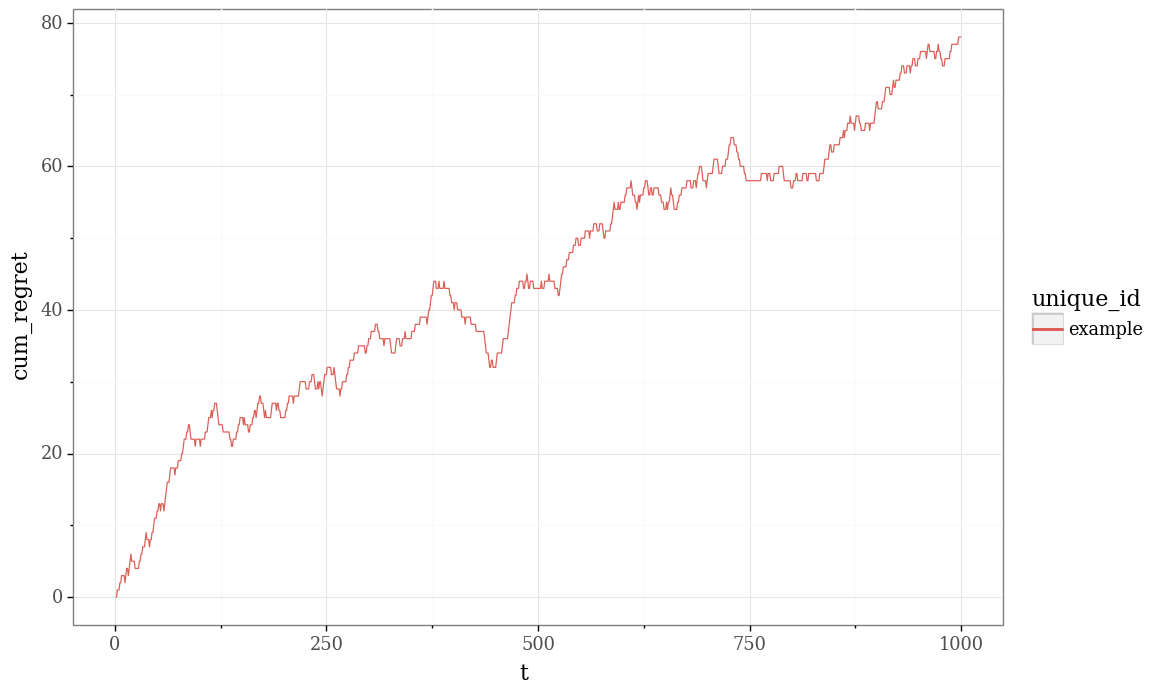

<ggplot: (7543781871)>
192 0.192


In [184]:
##############################################################################
# Simple display / plot of results

experiment.results.head()

p = (gg.ggplot(experiment.results)
     + gg.aes(x='t', y='cum_regret', colour='unique_id')
     + gg.geom_line())
print(p)

print(env.num_query, env.num_query/n_steps)

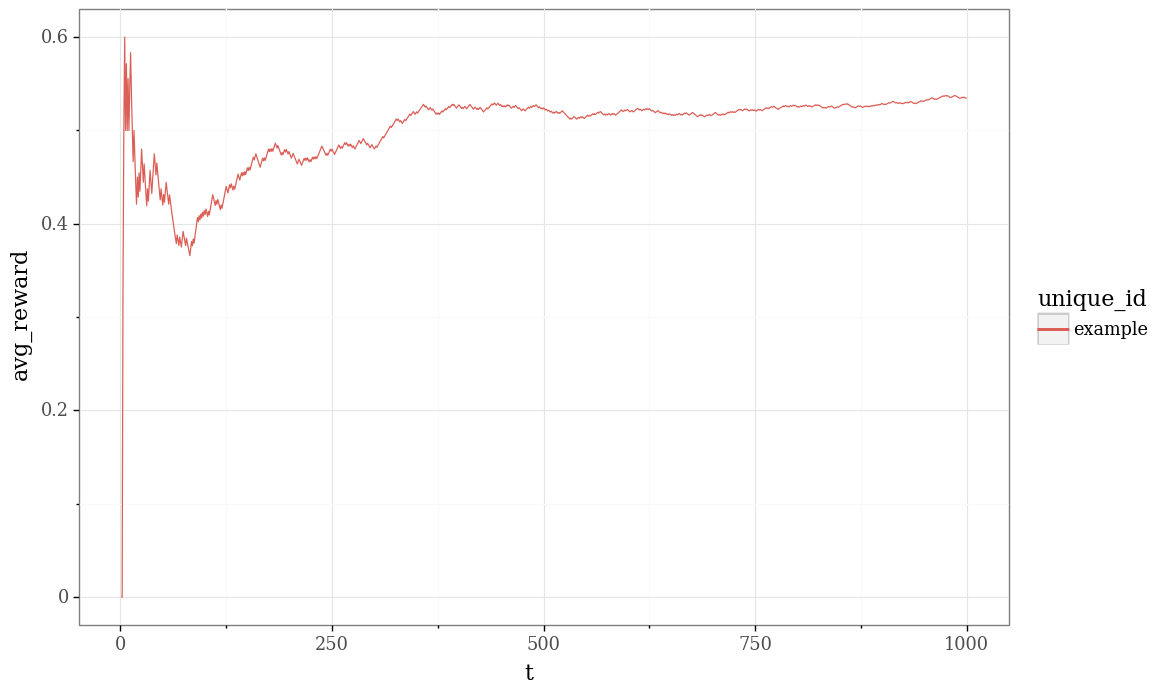

<ggplot: (7542553457)>
999 0.999


In [182]:
##############################################################################
# Simple display / plot of results

experiment.results.head()

p = (gg.ggplot(experiment.results)
     + gg.aes(x='t', y='avg_reward', colour='unique_id')
     + gg.geom_line())
print(p)

print(env.num_query, env.num_query/n_steps)

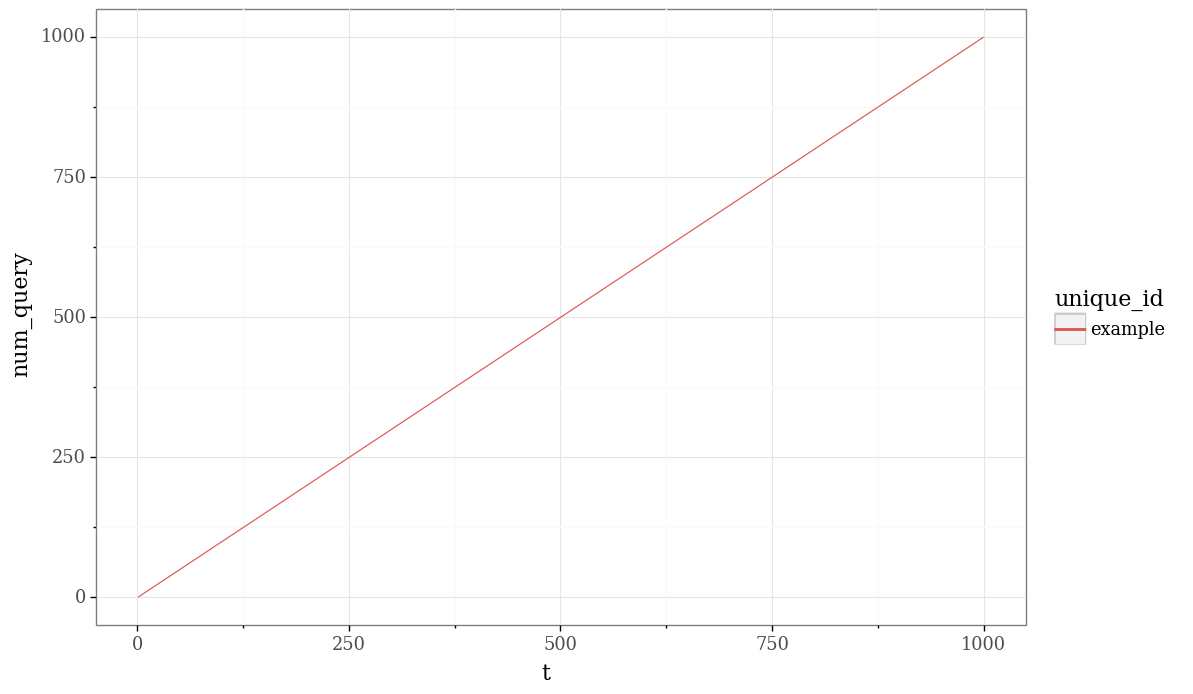

<ggplot: (-9223372029312037176)>
999 0.999


In [179]:
##############################################################################
# Simple display / plot of results

experiment.results.head()

p = (gg.ggplot(experiment.results)
     + gg.aes(x='t', y='num_query', colour='unique_id')
     + gg.geom_line())
print(p)

print(env.num_query, env.num_query/n_steps)

In [208]:
experiment.results

,t,instant_regret,cum_regret,action,unique_id,instant_reward,cum_reward,avg_reward,num_query,logger
0,1,1.0,1.0,"(0, 0.0)",example,0.0,0.0,0.000000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,1.0,2.0,"(1, 0.0)",example,0.0,0.0,0.000000,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,0.0,2.0,"(1, -1.0)",example,1.0,1.0,0.333333,2,"[0.000793536191272589, 0.004276198742548087, 0..."
3,4,1.0,3.0,"(1, 1.0)",example,0.0,1.0,0.250000,3,"[-0.007613339654397144, 0.004968320536256177, ..."
4,5,1.0,4.0,"(1, 1.0)",example,0.0,1.0,0.200000,4,"[-0.0048558380192018635, 0.0055163588837096045..."
...,...,...,...,...,...,...,...,...,...,...
995,996,0.0,207.0,"(1, -1.0)",example,1.0,789.0,0.792169,902,"[0.07996569469412312, 0.07309257141799108, -0...."
996,997,0.0,207.0,"(1, -1.0)",example,1.0,790.0,0.792377,903,"[0.08057443817048243, 0.07312312995195214, -0...."
997,998,1.0,208.0,"(1, -1.0)",example,0.0,790.0,0.791583,904,"[0.08005829517663554, 0.07323868329639005, -0...."
998,999,0.0,208.0,"(0, -1.0)",example,1.0,791.0,0.791792,904,"[0.08040306045077511, 0.07337797228134768, -0...."


In [209]:
agent.w_t

array([ 8.15552479e-02,  7.33492765e-02, -1.98180157e-02, -2.26037353e-02,
        2.86761671e-02, -8.92364788e-02,  1.30288338e-02,  8.74237657e-01,
        2.65555437e-02, -1.80833366e-02, -1.34079190e-02,  3.06114546e-02,
       -5.20892309e-03, -2.01726741e-03,  3.50472216e-02, -2.32303277e-02,
       -9.36219825e-03,  1.66937293e-02,  3.79733178e-02,  6.47858305e-02,
       -4.47044319e-02,  1.81826603e-03, -5.94472283e-03,  9.81529546e-02,
       -3.52938172e-02,  6.97930191e-02, -6.33720520e-02, -9.85737338e-03,
        1.36403863e-01, -3.44765281e-02, -7.24465917e-02, -3.60441029e-02,
       -1.16297619e-02, -1.85222925e-02, -8.89063764e-03, -9.59667752e-03,
        1.05434275e-01, -1.70142947e-02, -2.32722183e-02, -1.27953308e-02,
       -3.56452984e-02,  3.34496524e-03,  9.64131367e-03,  3.28369699e-02,
       -2.02158299e-03,  1.34842720e-03, -5.42592362e-02,  1.42717457e-02,
       -3.31680726e-02, -3.33085695e-03, -1.37585996e-02,  7.23883761e-03,
        5.05990428e-02, -

In [56]:
a=[np.sin(2*np.pi*10*(ts-1)/1000) + np.random.normal(loc=0.0, scale=0.1) for ts in range(1000)]
a=pd.DataFrame({'x':range(1000),'y':a})
p = (gg.ggplot(a)
     + gg.aes(x='x', y='y')
     + gg.geom_line())
print(p)